@author: SteveEckel

This example covers calculating the forces involved in the bichormatic force, or in the stimulated emission of light into two travelling wavepackets.  It attempts to replicate Fig. 1 of J. Söding, R. Grimm, Y. Ovchinnikov, P. Bouyer, and C. Salomon, Short-Distance Atomic Beam Deceleration with a Stimulated Light Force”, *Phys. Rev. Lett.* **78**, 1420 (1997) http://dx.doi.org/10.1103/PhysRevLett.78.1420

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pylcp
from IPython.display import HTML

### Let's start by defining the lasers, magnetic field, and Hamiltonian:

Because we are dealing with a two state system, we keep the Hamiltonian and the geometry relatively simple.  Note that because we have positive and negative frequencies about resonance, we will put the detuning on the lasers themselves.

The last thing to think about is the beat phase of the lasers.  I follow the phase convention of L. Aldridge, *The Bichromatic Force in Multi-Level Systems*, Ph.D. thesis, 2016.

In [2]:
# Make a method to return the lasers:
def return_lasers(delta, beta):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta, 'phase':np.pi/8},
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':-delta, 'beta':beta, 'phase':-np.pi/8},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta, 'phase':-np.pi/8},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':-delta, 'beta':beta, 'phase':np.pi/8},
        ], beam_type=pylcp.infinitePlaneWaveBeam)


# Standard two-level Hamiltonian:
Hg = np.array([[0.]])
He = np.array([[0.]])
mu_q = np.zeros((3, 1, 1))
d_q = np.zeros((3, 1, 1))
d_q[1, 0, 0] = 1.

hamiltonian = pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q)

magField = lambda R: np.zeros(R.shape)

### Let's look at the phase:

Let's specifically compare our electric field with Eq. 2.6 in L. Aldridge, *The Bichromatic Force in Multi-Level Systems*, Ph.D. thesis, 2016.

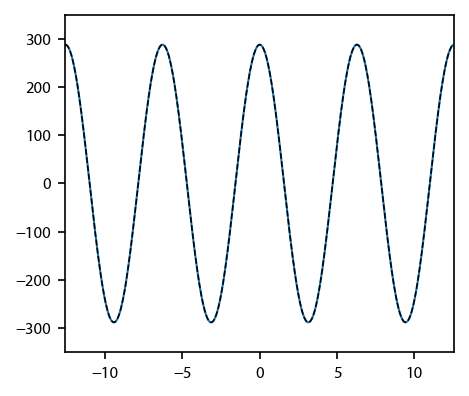

In [3]:
delta = 39.
beta = 2*39**2

laserBeams = return_lasers(delta, beta)
laserBeams_rightward = pylcp.laserBeams(laserBeams.beam_vector[:2])
laserBeams_leftward = pylcp.laserBeams(laserBeams.beam_vector[2:])

fig, ax = plt.subplots(1, 1)
line_thr, = ax.plot([], [], lw=1.0)
line_exp, = ax.plot([], [], lw=0.75, color='k', linestyle='--')

ax.set_ylim((-350, 350))
ax.set_xlim((-4*np.pi, 4*np.pi))

x = np.linspace(-4*np.pi, 4*np.pi, 1001)

def init():
    line_thr.set_data([], [])
    line_exp.set_data([], [])
    return (line_thr, line_exp)

def animate(i):
    t = i/50*(np.pi/delta)
    #ax.plot(x, np.real(laserBeams_rightward.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    #ax.plot(x, np.real(laserBeams_leftward.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    line_thr.set_data(x, np.real(laserBeams.total_electric_field(np.array([x,]+[np.zeros(x.shape)]*2), t))[1])
    line_exp.set_data(x, 4*np.sqrt(2*beta)*np.real(np.cos(x)*np.cos(delta*t)*np.cos(np.pi/8)+1j*np.sin(x)*np.sin(delta*t)*np.sin(np.pi/8)))
    
    return (line_thr, line_exp)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, 
                               blit=True);

HTML(anim.to_html5_video())

### Generate the force profile:

Using the same parameters as Fig. 1 of the PRL.  We also use the same time-ending criteria as Aldridge.

In [4]:
delta = 39
betas = [2*39**2, 2*43**2, 2*47**2]

v = np.arange(-50., 50.1, 0.5)

obe ={}
for beta in betas:
    laserBeams = return_lasers(delta, beta)
    
    obe[beta] = pylcp.obe(laserBeams, magField, hamiltonian, transform_into_re_im=True)
    obe[beta].generate_force_profile(
        np.zeros((3,) + v.shape),
        [v, np.zeros(v.shape), np.zeros(v.shape)],
        name='molasses', progress_bar=True,
        deltat_func=lambda r, v: 2*np.pi*(np.amin([10., 1./(np.linalg.norm(v)+1e-9)]) + 200./delta),
        itermax=3, rel=1e-4, abs=1e-6
    )

Completed in 24:29.                                                 
Completed in 26:26.                                                 
Completed in 28:30.                                                 


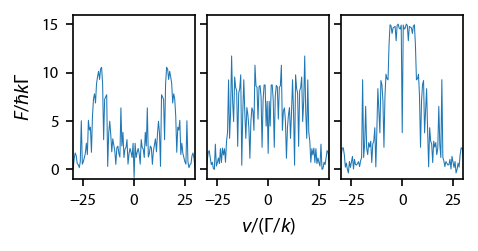

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(3.25, 1.5))
for ii, beta in enumerate(betas):
    ax[ii].plot(v, obe[beta].profile['molasses'].F[0], linewidth=0.5)
    ax[ii].set_ylim(-1, 16)
    ax[ii].set_xlim(-30, 30)

for ii in range(1, 3):
    ax[ii].yaxis.set_ticklabels('')
    
ax[0].set_ylabel('$F/\hbar k \Gamma$')
ax[1].set_xlabel('$v/(\Gamma/k)$')
fig.subplots_adjust(bottom=0.25)

In [12]:
fig.savefig('bichromatic_force.pdf')

'MyriadPro-It.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
